In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(num_train, img_channels, img_rows, img_cols)

50000 32 32 3


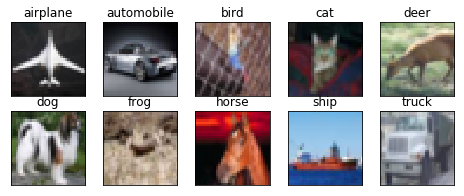

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [7]:
# mean value 
train_mean=np.array([0.4914, 0.4822, 0.4465])
train_mean

array([0.4914, 0.4822, 0.4465])

In [8]:
# std value 
train_std=np.array([0.2023, 0.1994, 0.2010])
train_std

array([0.2023, 0.1994, 0.201 ])

In [0]:
# function to normalize train and test image
train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from tensorflow.keras import layers,models

def add_batchnorm_relu(inp):
    inp = layers.BatchNormalization()(inp)
    inp = layers.ReLU()(inp)
    return inp

class Resnet:

    def __init__(self):
        self.img_height = 32
        self.img_width = 32
        self.img_channels = 3

    def build_resnet(self):
        _input = layers.Input(shape=(self.img_height, self.img_width, self.img_channels))
        inp = self.prep(_input)

        inp = self.down_sample(inp,128)
        shortcut = inp
        inp = self.block(inp,64,128)
        inp = layers.add([shortcut,inp])

        inp = self.down_sample(inp, 256)

        inp = self.down_sample(inp, 512)
        shortcut = inp
        inp = self.block(inp,128, 512)
        inp = layers.add([shortcut, inp])

        inp = layers.GlobalMaxPooling2D()(inp)
        out = layers.Dense(10,activation='softmax')(inp)

        model = models.Model(inputs=[_input], outputs=[out])
        return model

    def prep(self,inp):
        inp = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
        inp = add_batchnorm_relu(inp)
        return inp

    def down_sample(self,inp,channel_out):
        inp = layers.Conv2D(channel_out, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
        inp = add_batchnorm_relu(inp)
        inp = layers.MaxPool2D(pool_size=(2, 2))(inp)
        return inp

    def block(self,inp,channel_in,channel_out):
        inp = layers.Conv2D(channel_in, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
        inp = add_batchnorm_relu(inp)
        inp = layers.Conv2D(channel_out, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
        inp = add_batchnorm_relu(inp)
        return inp


In [12]:

resnet = Resnet()
model = resnet.build_resnet()
print(model.summary())

W0813 17:09:36.133821 140572909160320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

import keras
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
#from keras.losses import binary_crossentropy
#from keras.metrics import binary_accuracy
from tensorflow.keras import backend as K
#from keras.callbacks import *
from tensorflow.keras.callbacks import *

class SlantedCylicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum, inc_fraction):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        self.cycle_length = np.int(2*step_size)
        self.inc_fraction = inc_fraction
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
        
    def clr(self):
      
      cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
      
      if self.clr_iterations <= self.cycle_length*self.inc_fraction:
        unit_cycle = self.clr_iterations * 1 / (self.cycle_length * self.inc_fraction)
        adjusted_cycle = (unit_cycle * (self.max_lr - self.base_lr)) + self.base_lr
        return adjusted_cycle
      
      elif (self.cycle_length*self.inc_fraction < self.clr_iterations <= self.cycle_length):
        unit_cycle = (self.cycle_length - self.clr_iterations) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        adjusted_cycle = (unit_cycle * (self.max_lr - self.base_lr)) + self.base_lr
        return adjusted_cycle
        
      else:
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        adjusted_cycle = self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        return adjusted_cycle
               
  
    
    def cm(self):
      
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
      
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_train_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
          K.set_value(self.model.optimizer.momentum, self.cm())

          
          
    def on_train_batch_end(self, batch, logs=None):
      logs = logs or {}
      
     
    def on_test_begin(self, batch, logs=None):
      logs = logs or {}
      
    def on_test_end(self, batch, logs=None):
      logs = logs or {}  
      
    def on_test_batch_begin(self, batch, logs=None):
      logs = logs or {}
      
      
    def on_test_batch_end(self, batch, logs=None):
      logs = logs or {}
      
  

In [0]:

import tensorflow as tf
#something  = tf.keras.Sequential()
#from tf.keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(0.0000001), metrics=['accuracy'])

In [15]:
# CLR parameters

batch_size = 64
epochs = 20
max_lr = 0.50
base_lr = 0.05 # Min_lr is 1/10 of max_lr
max_m = 0.95
base_m = 0.9*max_m  # Min momentum as 90% of max momentum

cyclical_momentum = True
augment = True
cycles = 2.3  #Keep over 2.1 and below 2.6 this is the annealing portion

iters = round((train_features.shape[0]/batch_size)*epochs)
print("iterations",iters)
integer_cycles = np.round(cycles, 0)
print("Int cycl",integer_cycles )
fraction_cycles = np.round((cycles - integer_cycles), 4)
print("Fractional", fraction_cycles)
print("total iters - fractional", np.int(iters*(1-fraction_cycles)))
cycle_length = np.int(iters*(1-fraction_cycles))
print("Cycle_length", cycle_length)
iterations = list(range(0,iters+1))
step_size = len(iterations)/(cycles)

iterations 15625
Int cycl 2.0
Fractional 0.3
total iters - fractional 10937
Cycle_length 10937


In [0]:
slanted = SlantedCylicLR(base_lr=base_lr,max_lr=max_lr,step_size=step_size,base_m=base_m, max_m=max_m,cyclical_momentum=cyclical_momentum,inc_fraction=0.35)
   

In [0]:
import os
# checkpoint for saving weights whenever val acc increases
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="best_model_07_August_2019.hdf5"
checkpoint_dir = os.path.dirname(filepath)
# alternatively use this line for saving only the best weights, this will keep getting overwritten during fit -- filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#callbacks_list = [checkpoint, clr]
slant_callback = [checkpoint, slanted]

In [18]:
# Train the model by fitting the training data to the one-hot-encoded training labels, include callback to scheduler for learning rate
start = time.time()
datagen = ImageDataGenerator(zoom_range=0.15, 
                            horizontal_flip=True, rotation_range=10,)
history = model.fit_generator(datagen.flow(train_features, train_labels, batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=1*(train_features.shape[0] // batch_size),
                        validation_data=(test_features, test_labels),
                        callbacks=slant_callback,verbose=1)


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





# train the model

# Train the model
#model_info = model.fit(datagen.flow(train_features, train_labels, batch_size = 128),
#                                  nb_epoch = 10, 
#                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


Epoch 1/20
779/781 [============================>.] - ETA: 0s - loss: 4.1128 - acc: 0.2579
Epoch 00001: val_acc improved from -inf to 0.35300, saving model to best_model_07_August_2019.hdf5
781/781 [==============================] - 35s 45ms/step - loss: 4.1085 - acc: 0.2582 - val_loss: 2.1916 - val_acc: 0.3530
Epoch 2/20
780/781 [============================>.] - ETA: 0s - loss: 1.7620 - acc: 0.4682
Epoch 00002: val_acc improved from 0.35300 to 0.54410, saving model to best_model_07_August_2019.hdf5
781/781 [==============================] - 30s 39ms/step - loss: 1.7612 - acc: 0.4683 - val_loss: 1.3198 - val_acc: 0.5441
Epoch 3/20
780/781 [============================>.] - ETA: 0s - loss: 1.1385 - acc: 0.6093
Epoch 00003: val_acc improved from 0.54410 to 0.66550, saving model to best_model_07_August_2019.hdf5
781/781 [==============================] - 30s 38ms/step - loss: 1.1380 - acc: 0.6095 - val_loss: 0.9877 - val_acc: 0.6655
Epoch 4/20
780/781 [============================>.] - E

In [0]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

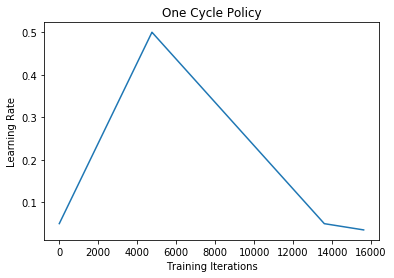

In [19]:
# Plot Learning Rate

plt.plot(slanted.history['iterations'], slanted.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

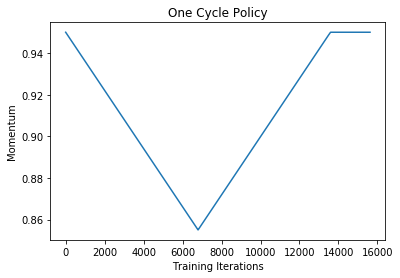

In [20]:
# Plot momentum

plt.plot(slanted.history['iterations'], slanted.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

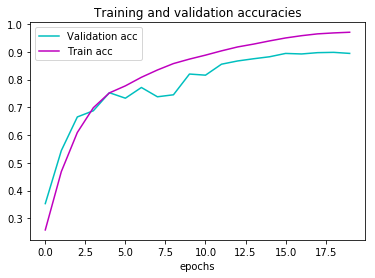

In [21]:
# Plot accuracies
val_acc = history.history['val_acc']
acc = history.history['acc']
plt.plot(range(len(val_acc)),val_acc,'c',label='Validation acc')
plt.plot(range(len(acc)),acc,'m',label='Train acc')

plt.title('Training and validation accuracies')
plt.legend()
plt.xlabel('epochs')
plt.show()